In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import delayed, Parallel
from scipy.stats import zscore
from scipy import stats
from scipy.optimize import curve_fit
from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
# from utils.relaxation_time import RelaxationTime
from PyIF import te_compute as te
import time

import warnings
warnings.filterwarnings('ignore')

/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
ad_te_sr_z = np.load('/home/shivansh.seth/phase_diagram_analysis/results/ad_te_ss.npy')
cn_te_sr_z = np.load('/home/shivansh.seth/phase_diagram_analysis/results/cn_te_ss.npy')

In [3]:
sr = np.load('results/significant_regions_ss.npy')
sk_flat = np.load('skull_indices_flat.npy')

In [5]:
ad_te_sr_z[0].shape

(222, 31569)

In [10]:
sr_sk = []
for i in sr:
    sr_sk.append(np.where(sk_flat == i)[0][0])

In [11]:
sr_sk

[1895,
 4639,
 5830,
 8576,
 8580,
 9069,
 9685,
 9686,
 9717,
 9718,
 9751,
 9752,
 10608,
 10702,
 10732,
 10733,
 10734,
 10762,
 10763,
 10764,
 10765,
 10766,
 10767,
 10768,
 10776,
 10796,
 10797,
 10798,
 10799,
 10800,
 10831,
 10835,
 10864,
 10868,
 10898,
 10899,
 10973,
 11009,
 11010,
 11042,
 11043,
 11045,
 11127,
 11697,
 11733,
 11756,
 11760,
 11815,
 11816,
 11817,
 11821,
 11827,
 11828,
 11849,
 11850,
 11851,
 11853,
 11883,
 11885,
 11887,
 11917,
 11918,
 12005,
 12192,
 12221,
 12857,
 12868,
 12869,
 12901,
 12924,
 12958,
 12970,
 13006,
 13036,
 13047,
 13084,
 13085,
 13122,
 13730,
 13780,
 13804,
 13836,
 13837,
 13880,
 13913,
 13946,
 13948,
 13977,
 13981,
 14048,
 14049,
 14063,
 14085,
 14086,
 14087,
 14095,
 14126,
 14140,
 14186,
 14327,
 14334,
 14351,
 14744,
 14773,
 14863,
 14881,
 14895,
 14907,
 14910,
 14935,
 14936,
 14941,
 14942,
 14976,
 14977,
 15004,
 15041,
 15077,
 15079,
 15080,
 15129,
 15166,
 15179,
 15750,
 15767,
 15796,
 157

In [ ]:
sns.heatmap(ad_te_sr_z[0])

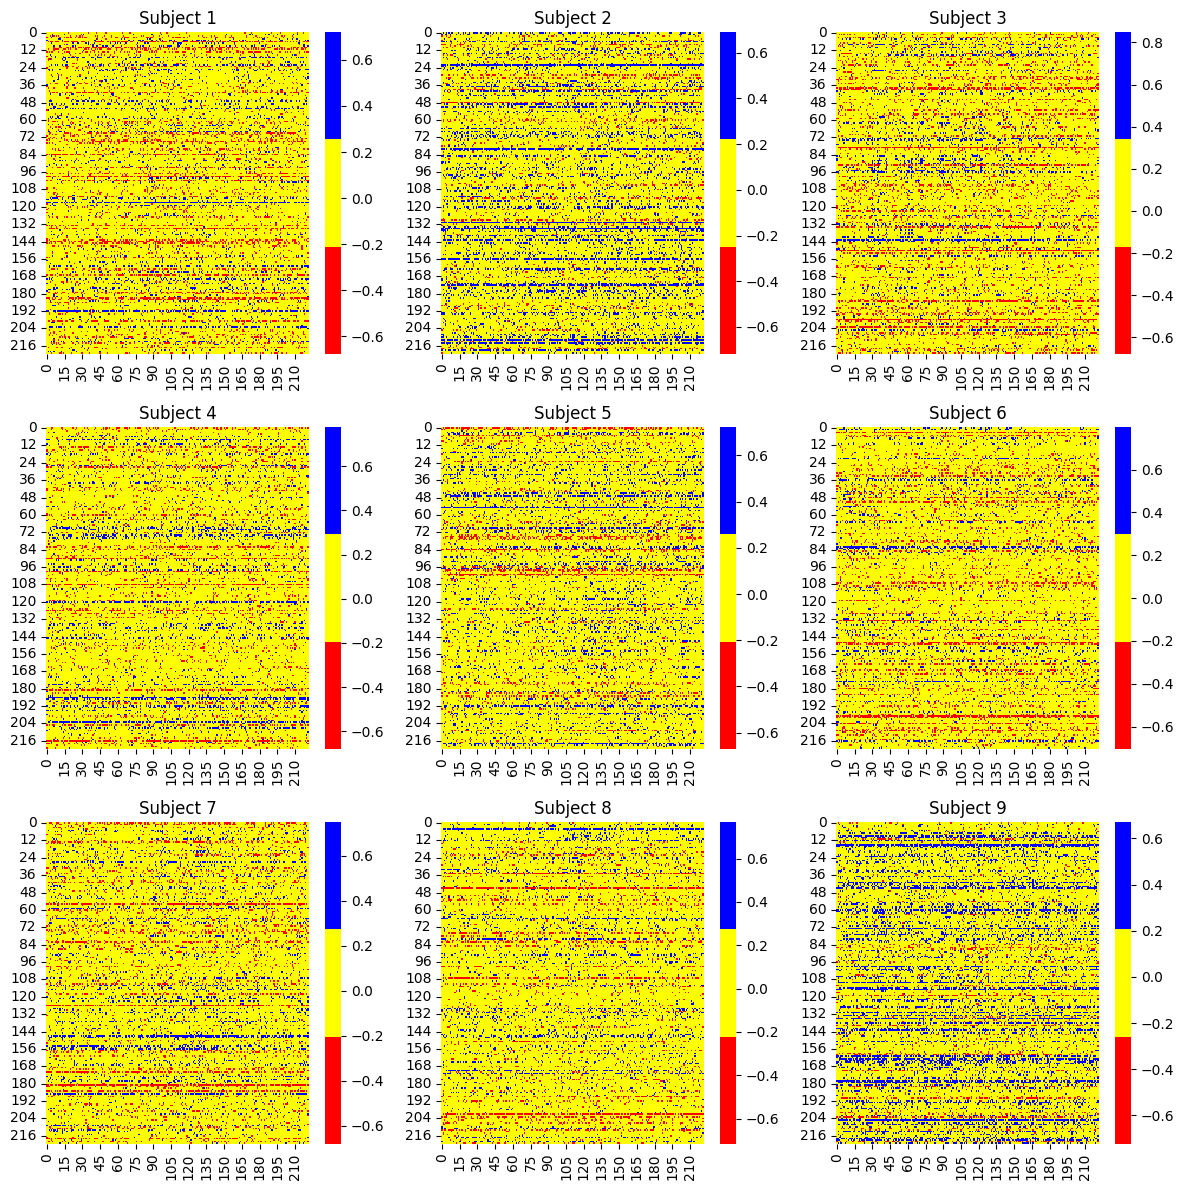

In [14]:
n = 9
grid_size = int(np.ceil(np.sqrt(n)))
fig, axs = sns.mpl.pyplot.subplots(grid_size, grid_size, figsize=(12, 12))
ryb_colors = sns.color_palette(['red', 'yellow', 'blue'])

# Loop over the subplots and plot each heatmap
for i in range(n):
    row, col = divmod(i, grid_size)
    subplot_data = ad_te_sr_z[i][:, sr_sk]
    sns.heatmap(subplot_data, cmap=ryb_colors, ax=axs[row, col])
    axs[row, col].set_title('Subject {}'.format(i+1))

# Adjust the layout and show the plot
sns.mpl.pyplot.tight_layout()
sns.mpl.pyplot.show()

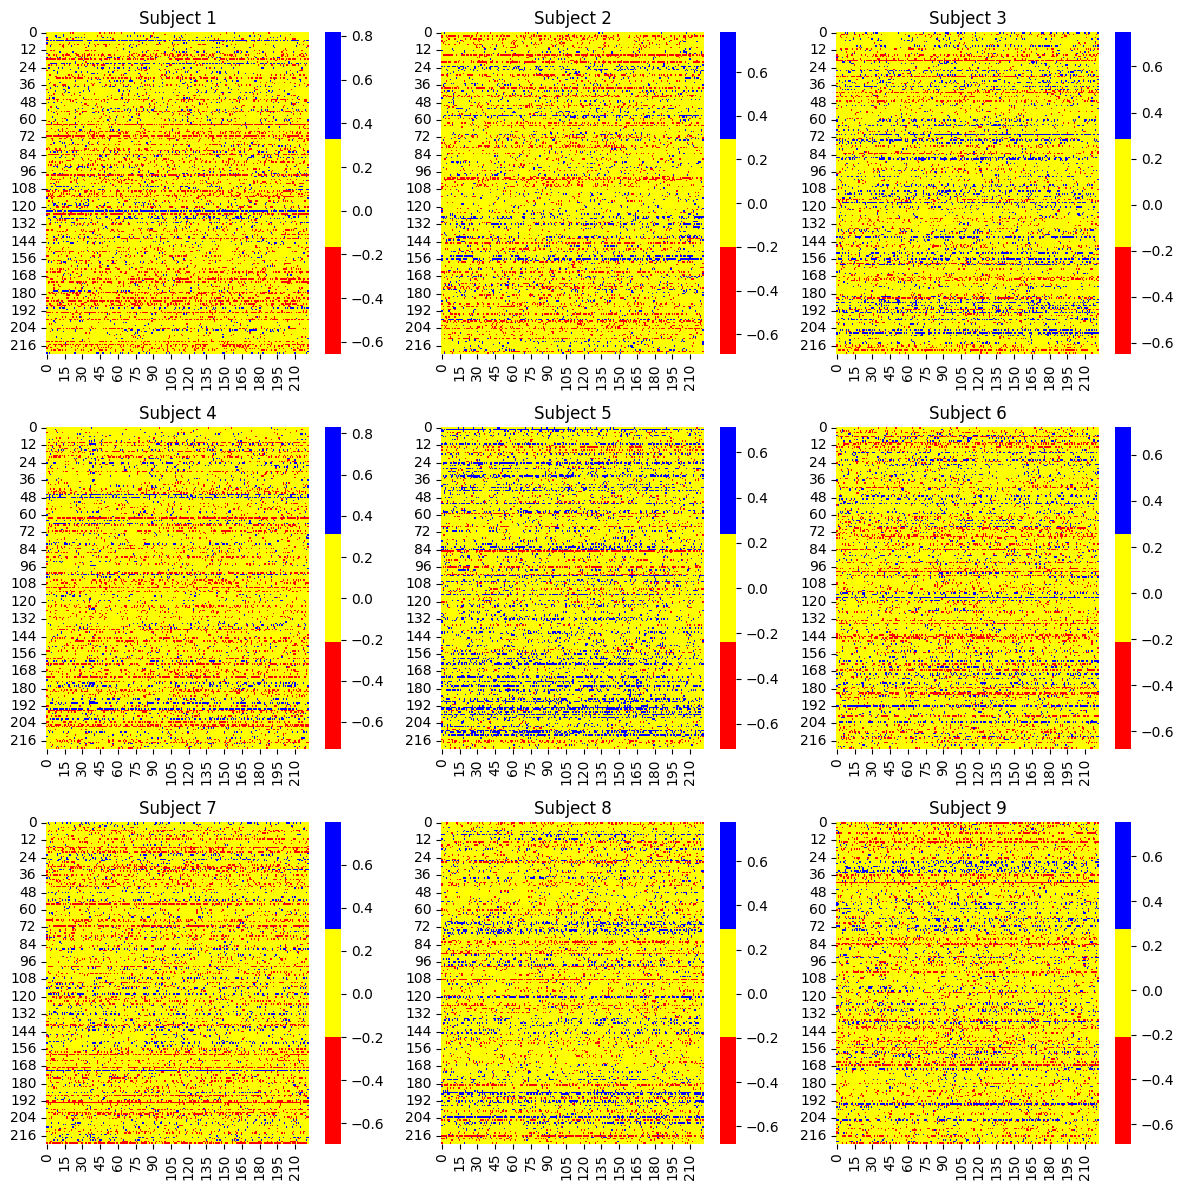

In [15]:
n = 9
grid_size = int(np.ceil(np.sqrt(n)))
fig, axs = sns.mpl.pyplot.subplots(grid_size, grid_size, figsize=(12, 12))

# Loop over the subplots and plot each heatmap
for i in range(n):
    row, col = divmod(i, grid_size)
    subplot_data = cn_te_sr_z[i][:, sr_sk]
    sns.heatmap(subplot_data, cmap=ryb_colors, ax=axs[row, col])
    axs[row, col].set_title('Subject {}'.format(i+1))

# Adjust the layout and show the plot
sns.mpl.pyplot.tight_layout()
sns.mpl.pyplot.show()

### Distribution

In [22]:
cn_te_f[:, :, sr_sk].shape

(10, 222, 222)

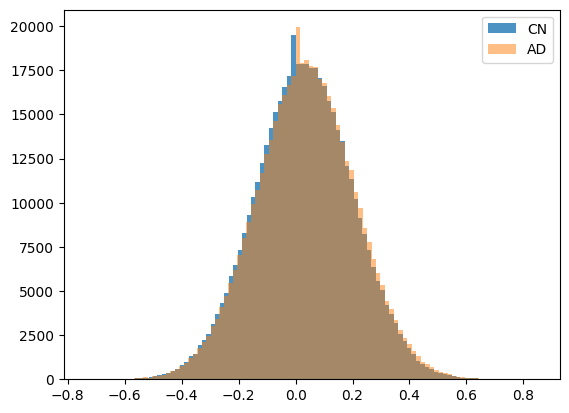

In [23]:
cn_te_f = np.copy(cn_te_sr_z)
# cn_te_f = np.delete(cn_te_sr_z, 6, axis=0)
ad_te_f = np.copy(ad_te_sr_z)
# ad_te_f = np.delete(ad_te_sr_z, 3, axis=0)
ax1=plt.hist(cn_te_f[:, :, sr_sk].flatten(), bins=100, label='CN', alpha=0.8)
ax2=plt.hist(ad_te_f[:, :, sr_sk].flatten(), bins=100, label='AD', alpha=0.5)
plt.legend()
plt.show()

### P-value calculation

In [25]:
ad_te_sr_z_flat = ad_te_f[:, :, sr_sk].reshape(len(ad_te_f), -1)
cn_te_sr_z_flat = cn_te_f[:, :, sr_sk].reshape(len(cn_te_f), -1)

print(ad_te_sr_z_flat.shape, cn_te_sr_z_flat.shape)
t, p = stats.ttest_ind(ad_te_sr_z_flat, cn_te_sr_z_flat)
len(np.where(p < 0.05)[0])

(10, 49284) (10, 49284)


1399

#### Random Split

In [29]:
merged = np.concatenate([ad_te_sr_z_flat, cn_te_sr_z_flat])
indices = np.random.permutation(len(merged))
split1 = merged[indices[:len(merged)//2]]
split2 = merged[indices[len(merged)//2:]]
print(split1.shape, split2.shape)
t, p = stats.ttest_ind(split1, split2)
len(np.where(p<0.05)[0])

(10, 49284) (10, 49284)


2649

## $|a_i - b_i|$

In [14]:
ad_te_sum = np.load('results/ad_te_mean_og.npy')
cn_te_sum = np.load('results/cn_te_mean_og.npy')

In [15]:
# Calculate pairwise absolute difference between rows
abs_diff = np.abs(ad_te_sum[:, np.newaxis, :] - cn_te_sum[np.newaxis, :, :])
# Stack the results to get a (100, 251) array
abs_diff_reshaped = abs_diff.reshape(-1, abs_diff.shape[-1])

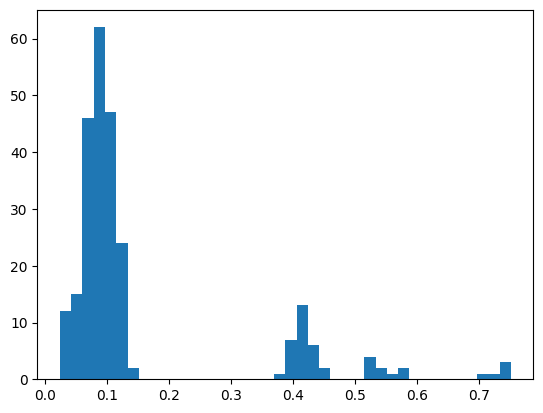

In [16]:
plt.hist(np.mean(abs_diff_reshaped, axis=0), bins=40)
plt.show()

<Axes: >

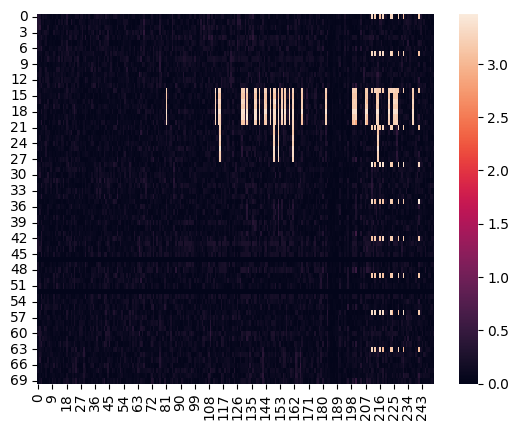

In [17]:
sns.heatmap(abs_diff_reshaped)

In [19]:
t_vals, p_vals = stats.ttest_1samp(abs_diff_reshaped, np.mean(abs_diff_reshaped, axis=0))

In [21]:
p_vals

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.